# IV. Fluorence of a two-level atom

Consider a two-level atom with ground state |g⟩ and excited state |e⟩ driven by a coherent laser field. The Hamiltonian of the two-level atom is 
$\begin{equation}
H=-\frac{\hbar\delta}{2}\sigma_z + \frac{\hbar\Omega}{2}(\sigma_+ + \sigma_-),
\end{equation}$
where $\delta = \omega_L - \omega_0$ is the detuning parameter, $\Omega$ is the Rabi frequency. We will consider $\hbar = 1$ for computional purpose.
With Markovian dissipation accounting for spontaneous emission $\Gamma_e$, the dynamics of the system is governed by the Lindblad master equation
$\begin{equation}
\frac{d\rho_S}{dt} = -\frac{i}{\hbar}[H, \rho_S] + \Gamma_e \left( \sigma_- \rho_S \sigma_+ - \frac{1}{2} \left\{ \sigma_+ \sigma_-, \rho_S \right\} \right).
\end{equation}$

At non-zero temperature, one should replace the dissipative term in Eq. (2) by
$\begin{equation}
\Gamma_e(\bar{n}+1)\left(\sigma_{-}\rho\sigma_{+} - \frac{1}{2} \left\{ \sigma_{+}\sigma_{-}, \rho \right\} \right)+
 \Gamma_e \bar{n} \left(\sigma_{+}\rho\sigma_{-} - \frac{1}{2} \left\{ \sigma_{-}\sigma_{+}, \rho \right\} \right),
\end{equation}$
where $\bar{n} = \left(e^{\hbar \omega_0 / k_B T} - 1\right)^{-1}$  is the mean number of thermal photons of energy $\hbar\omega_0$ at temperature $T$.
When the atom also undergoes pure dephasing at a rate  $\Gamma_d$, the following term must be added to the master
 equation :
$\begin{equation}
\Gamma_d \left( \sigma_z \rho \sigma_z - \frac{1}{2} \left\{ \sigma_z \sigma_z, \rho \right\} \right).
\end{equation}$

### installing & loading packages

In [ ]:
using Pkg

Pkg.add("QuantumOptics")
Pkg.add("CairoMakie")
Pkg.add("LaTeXStrings")
Pkg.add("LinearAlgebra")
Pkg.add("FFTW")
Pkg.add("Plots")
# Pkg.update()

In [1]:
using QuantumOptics
using CairoMakie
using LaTeXStrings
using LinearAlgebra
using FFTW
using GLMakie

import Plots as P
colors=P.palette(:tab10)

# Question 1)

## a) Solving for the *steady-state* density matrix $\rho$ and expressing it in the Bloch sphere

\begin{equation*}
\frac{d\rho_S}{dt} = -\frac{i}{\hbar}[H, \rho_S] + \Gamma_e \left( \sigma_- \rho_S \sigma_+ - \frac{1}{2} \left\{ \sigma_+ \sigma_-, \rho_S \right\} \right).
\end{equation*}

#### Parameters :

In [2]:
#basis
b = NLevelBasis(2)

#parameters
ω0 = 1                  #Transition frequency between |e> and |g>
ωL = 1                  #Frequency of the Laser
δ = ωL - ω0             #Detuning
Ωs = [0,0.1,0.5,1,5,10] #List of Rabi frequencies
Γe = 1                  #Spontaneous emission rate
Γd = 0                  #Dephasing rate
T = 0;                  #Temperature



#### System :

In [4]:
#System 
b = NLevelBasis(2)
σ_z = transition(b,2,2)-transition(b,1,1)
σ_p = transition(b,2,1)
σ_m = transition(b,1,2)

#Hamiltonian
h(δ,Ω) = -δ/2*σ_z + Ω/2*(σ_p + σ_m) 

#Evolution
tspan = 0:0.05:10
rates = [Γe]
J = [σ_m]

#Spontaneous emission rate depending on T
if T > 0
    n = 1/(exp(ω0/T) - 1)
    rates = [Γe * (n + 1), Γe * n]
    J = [σ_m, σ_p]
end

#Dephasing
if Γd > 0
  push!(rates,Γd)
  push!(J,σ_z)
end;

#Initial state
ψ0 = nlevelstate(b,2)   
ψ0 = tensor(ψ0,ψ0'); 

#### Evolution of the excited state population depending on time, for different values of $\frac{\Omega}{\Gamma_e}$ :

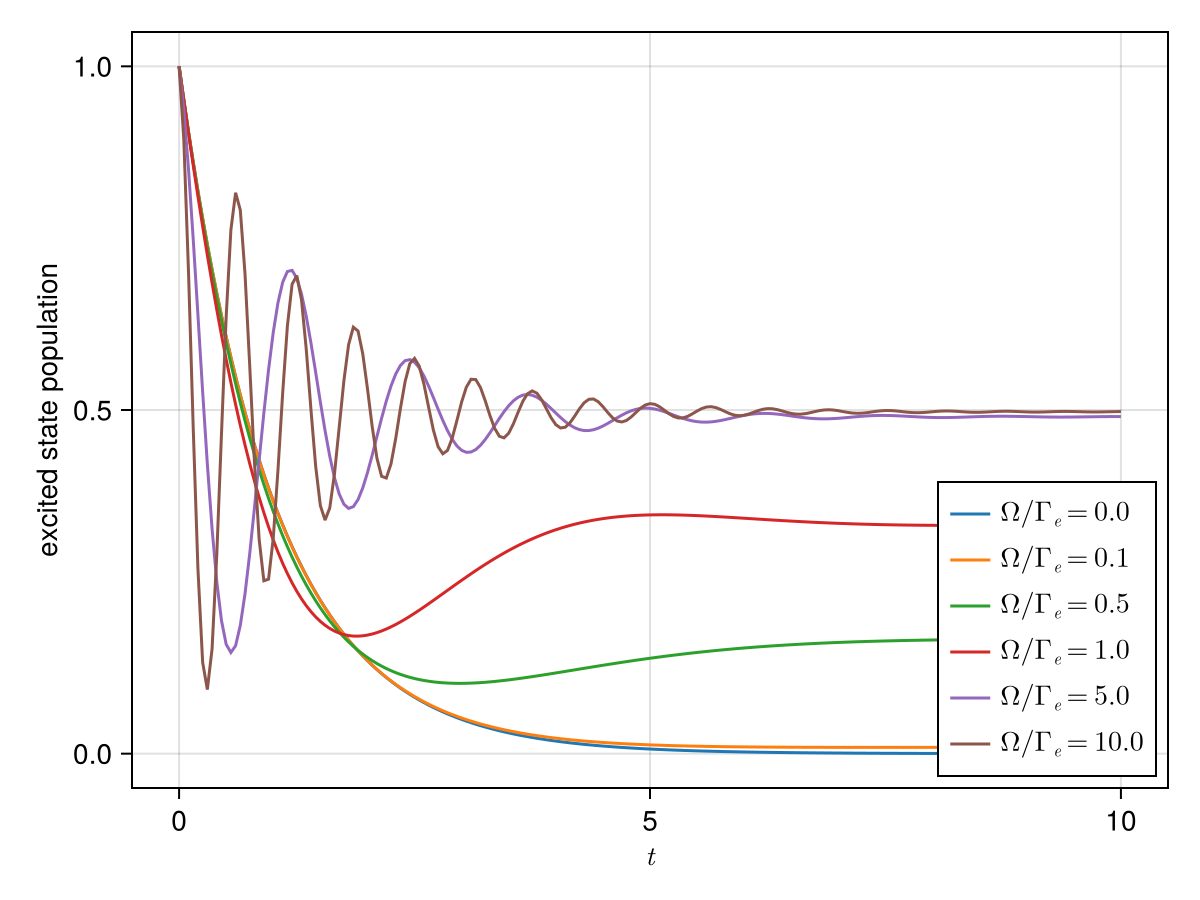

In [4]:
#Figure
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"t", ylabel="excited state population")

for (i,Ω) in enumerate(Ωs)
    #time evolution
    tout, ψt=timeevolution.master(tspan,ψ0,h(δ, Ω),J; rates)
    #expectation value
    exp_pt=real(expect(transition(b,2,2),ψt))
    #plotting
    lines!(ax, tspan, exp_pt, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end
axislegend(ax,position=:rb)

fig

#### Bloch ball representation :

In [29]:
#Pauli matrices

σ_x = transition(b,1,2)+transition(b,2,1)
σ_y = 1im*(transition(b,2,1)-transition(b,1,2))
paulis = [σ_x, σ_y, σ_z]

#Vector to save the position of the Bloch vector
positions = Vector{Vector{Float64}}()
println("Bloch vector norm positions for different values of Ω/Γ_e :")
println("-----------------------------------------------------")
#Steady state 
for (i,Ω) in enumerate(0:0.1:1)
    # ρ_ss = steadystate.eigenvector(h(δ,Ω), J; rates = rates)
    ψ =(nlevelstate(b,2)+nlevelstate(b,1))/sqrt(2)
    ρ_ss=dm(ψ)
    λ = [real(tr(ρ_ss * σ)) for σ in paulis]
    println("|λ| = ", norm(λ)," for Ω/Γe = ",Ω/Γe)
    push!(positions,λ)
end

#use this command if you want an interactive figure
#GLMakie.activate!()

#Figure
set_theme!(fonts = ( ; regular = "Arial", bold = "Times New Roman Bold"))
x = [p[1] for p in positions]
y = [p[2] for p in positions]
z = [p[3] for p in positions]
figure = Figure(fontsize=24)
axis = Axis3(figure[1, 1], aspect = :data, title="Bloch ball Representation")
#hidedecorations!(axis)
#hidespines!(axis)
sphere = GLMakie.Sphere(Point3f(0), 1)
GLMakie.wireframe!(axis,sphere; linewidth=0.5, color=:orange)
meshscatter!(axis,x,y,z, markersize=0.05)

figure

Bloch vector norm positions for different values of Ω/Γ_e :
-----------------------------------------------------
|λ| = 0.9999999999999998 for Ω/Γe = 0.0
|λ| = 0.9999999999999998 for Ω/Γe = 0.1
|λ| = 0.9999999999999998 for Ω/Γe = 0.2
|λ| = 0.9999999999999998 for Ω/Γe = 0.3
|λ| = 0.9999999999999998 for Ω/Γe = 0.4
|λ| = 0.9999999999999998 for Ω/Γe = 0.5
|λ| = 0.9999999999999998 for Ω/Γe = 0.6
|λ| = 0.9999999999999998 for Ω/Γe = 0.7
|λ| = 0.9999999999999998 for Ω/Γe = 0.8
|λ| = 0.9999999999999998 for Ω/Γe = 0.9
|λ| = 0.9999999999999998 for Ω/Γe = 1.0


## b) Computing the number of fluorescence cycles per second 

#### The number of fluorescence cycles per second is given by $R=\Gamma_e \langle P_e \rangle_{\rho_{ss}}$ with $P_e= \ket{e}\bra{e}$ the population of the excited state.

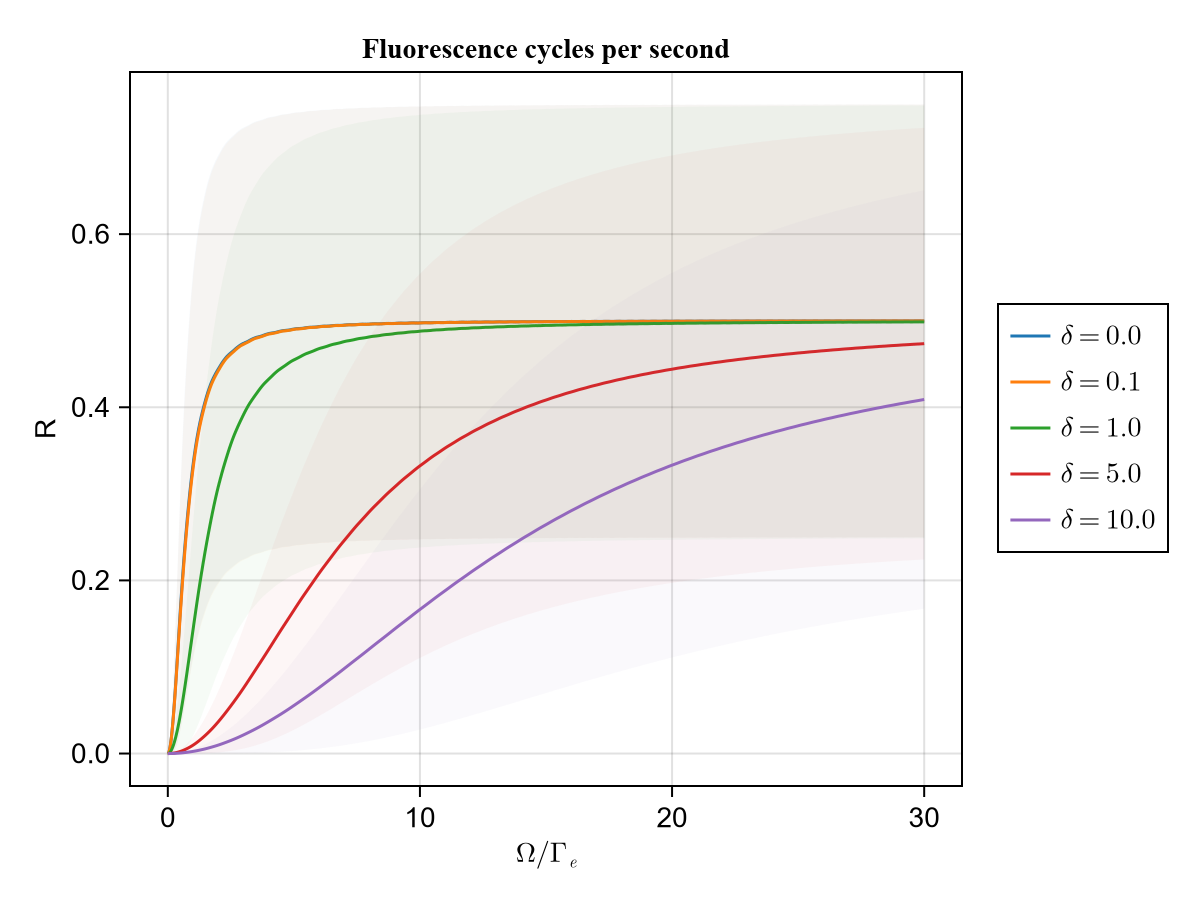

CairoMakie.Screen{IMAGE}


In [6]:

Ωs=0:0.01:30
δs=[0,0.1,1,5,10]

fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\Omega/\Gamma_e", ylabel="R",title="Fluorescence cycles per second")
for (j,δ) in enumerate(δs)
    cycles=[]
    cycles_std=[]
    for (i,Ω) in enumerate(Ωs)
        tout, ρ_master = steadystate.master(h(δ,Ω), J)
        push!(cycles,real(expect(transition(b,2,2),ρ_master[end]))*rates[1])
        push!(cycles_std,real(variance(transition(b,2,2),ρ_master[end]))*rates[1])
    end
    lines!(ax, Ωs, cycles, label=L"\delta=%$δ",color=colors[j])
    #error bars
    band!(ax, Ωs, cycles .- cycles_std, cycles .+ cycles_std, color=colors[j], alpha=0.2)
end
Legend(fig[1,2],ax)
display(fig)

## c) Discussing the graphic, especially the limiting cases when $\Omega = 0$ and $\Omega >> \Gamma_e$

As it was intuitively expected, one can see that the smaller the detuning, the steeper the slope. It is due to the fact that when $\delta -> 0$, it means that thje laser is in resonnace with the atomic transition, so it is normal that the number of excited states growths faster than other values for $\delta$.  
Moreover, concerning the specific case of $\Omega = 0$, it can be seen that there is trivially not any fluorescence cycle occuring, simply because there is no laser driving.  
Finally, when $\Omega >> \Gamma_e$, in function of the detuning $\delta$, the fluorescence rate reaches a horizontal asymptote of a fluorescence cycles rate of 0.5. This value is not suprising as when the system is in its excited state, it quasi-spontaneously comes back down to its ground state, emmiting a photon. 


# Question 2)

## a) Calculating (and plotting) via $\langle \sigma^+(\tau)\, \sigma^-(0) \rangle_{\mathrm{ss}}$ by using the *quantum regression theorem*

In general, calculating the correlation function between two observables A and B at two different times: $\langle A(t +\tau)\, B(t) \rangle_{}$, constitutes a quite arduous task because along time, the state of the system evolves and is influenced by its environment. Basically, the QTR makes use of a hint under the condition that the system is under stationnary regime. This theorem says that: 
$$\langle A(t +\tau)\, B(t) \rangle_{} = Tr[Ae^{\mathcal{L}t}(B\rho_{ss})]$$

#### Calculation of the two-time correlation function $\langle \sigma_+(\tau)\sigma_-(0)\rangle$.

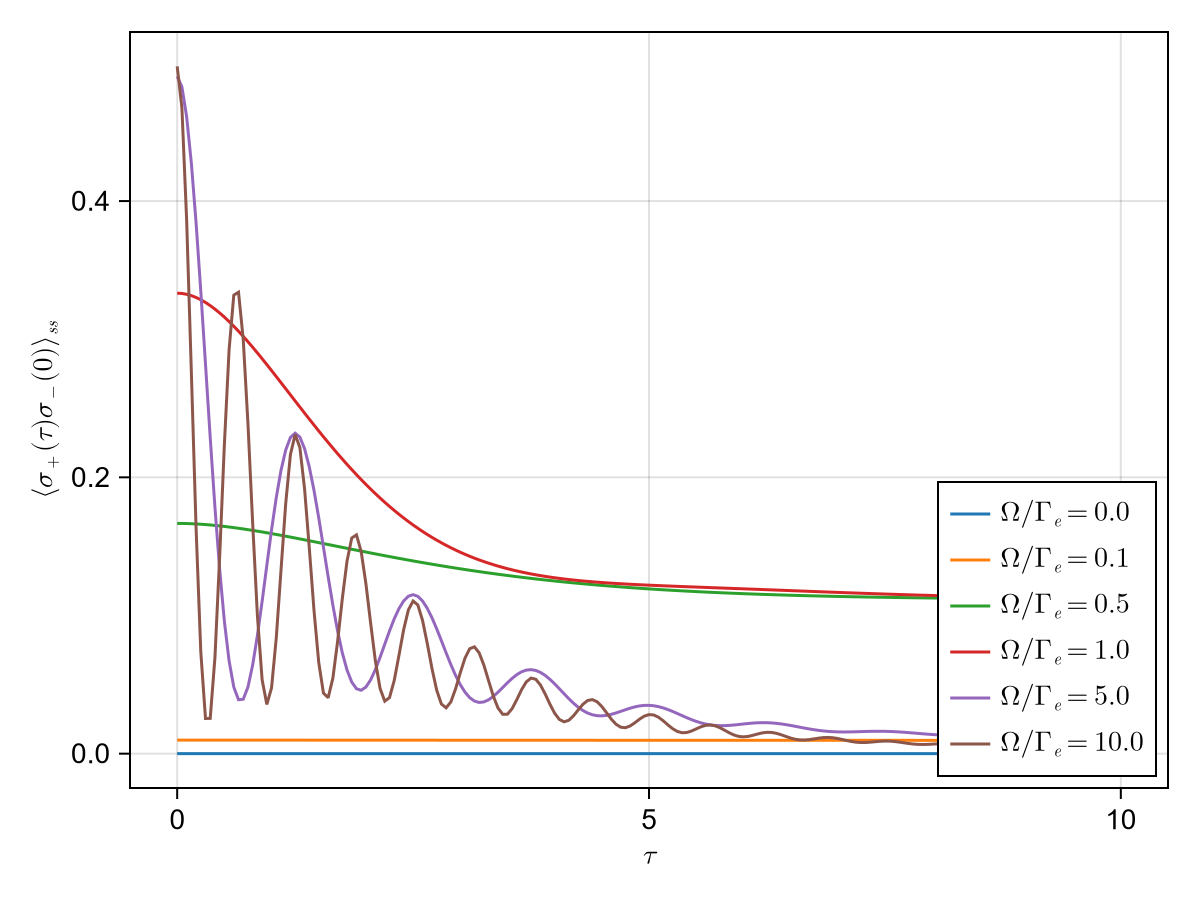

In [7]:
τs = 0:0.05:10 #List of τ
Ωs = [0,0.1,0.5,1,5,10] # Redefinition of the different Rabi frequencies


CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle_{ss}")

for (i,Ω) in enumerate(Ωs)
    ρ0 = steadystate.eigenvector(h(δ,Ω), J; rates = rates)
    corr = timecorrelations.correlation(τs, ρ0, h(δ,Ω), J, σ_p, σ_m; rates = rates)
    lines!(ax, τs, real(corr), label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

# Question 3) 

## a) Calculation of the fluorescence spectrum $S(\omega) = \int_{-\infty}^{\infty} d\tau\, e^{i \omega \tau} \left\langle \sigma^+(\tau)\, \sigma^-(0) \right\rangle_{\text{ss}}$ and plotting it for different values of $\Omega/\Gamma_e$ and $\delta/\Gamma_e$, and giving a physical interpretation of the *Mollow triplet*

#### Calculating and plotting $S(\omega)$

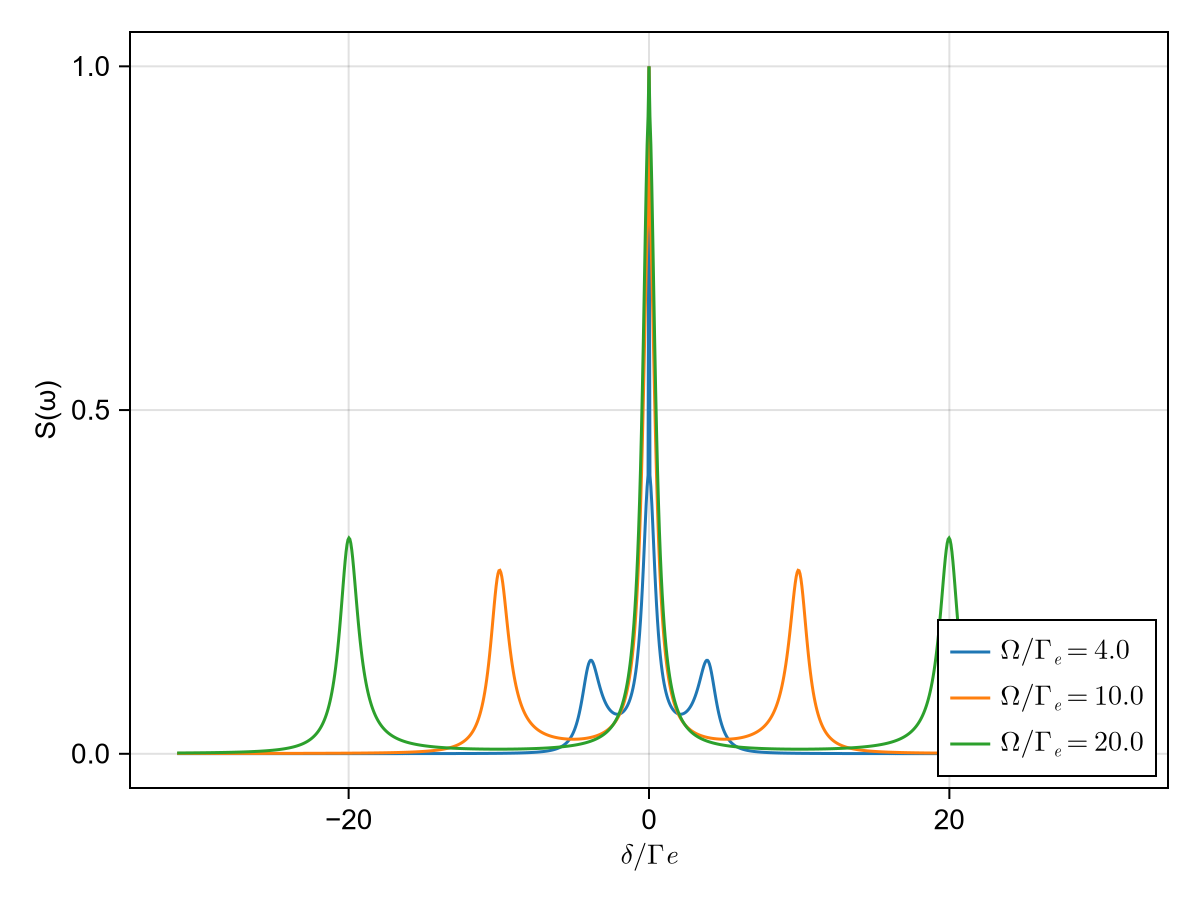

In [8]:
function fourier_transform_discrete(f_vals, t, ν)   
    dt = step(t) 
    return sum(f_vals .* exp.(-im* 2π * ν * t)) * dt
end

Ωl = [4,10,20]     #List of Rabi frequencies
νs = -5:0.01:5     #List of frequencies
τlist = 0:0.001:50 #List of τ

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"δ/Γe", ylabel="S(ω)")

for (i,Ω) in enumerate(Ωl)
    result=[]
    ρ0 = steadystate.eigenvector(h(δ,Ω), J; rates = rates)
    corr = timecorrelations.correlation(τlist, ρ0, h(δ,Ω), J, σ_p, σ_m; rates = rates)
    for (i,ν) in enumerate(νs)
        push!(result, fourier_transform_discrete(corr,τlist,ν))
    end
    lines!(ax,2π*νs, real(result)./maximum(real(result)), label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

It can clearly be noticed that for each value of $\Omega/\Gamma_e$ (and if this latter ratio is sufficiently large), the presence of three peaks in the fluorescence spectrum appearing symmetricaly. It can be added that, the greater the laser driving, the higher and the farther from the center the peaks.

#### Explanation of the Mollow triplet

To this purpose, some quantum optics reminders are necessary. Neglecting the reservoir contriubution and supposing the interaction resonant or almost resonant, the Hamiltonian of a system constituted by an atom interacting with a monochromatic electromagnetic field (thus with a single populated mode, say $L$) is given by 
$$
\hat{H} = \hat{H}_A + \hat{H}_L + \hat{V}_{AL}
$$
Here, we will trivially focus on the case of a two-level atom with the eigenstates $\ket{a}$ and $\ket{b}$, of eigen energies $E_a$ and $E_b$ respectively. With some elementary calculation, it can be demonstrated that, first neglecting the coupling between the monochromatic electromagnetic field and the atom, that, depending on $n$, the eigenenergies of $\hat{H}_A + \hat{H}_L$ are given by 
$$
E_{a,n} = n\hbar\omega + \hbar\omega_0 + E_b + \frac{\hbar\omega}{2}\\      
E_{b,n} = n\hbar\omega + E_b + \frac{\hbar\omega}{2} \ ,
$$
and then
$$
E_{b,n+1} = E_{a,n} = \hbar\delta \ .
$$
If the atom and the single-mode field did not interact with each other, the eigenstates would be $\ket{a,n}$ and $\ket{b,n+1}$.
Now considering the interaction $\hat{V}_{AL}$, which in the length gauge is given by 
$$
\hat{V}_{AL} = - \hat{\vec{d}} \cdot \hat{\vec{E}}
$$


# Question 4)

## a) Constructing the Liouvillian superoperator $\mathcal{L}$

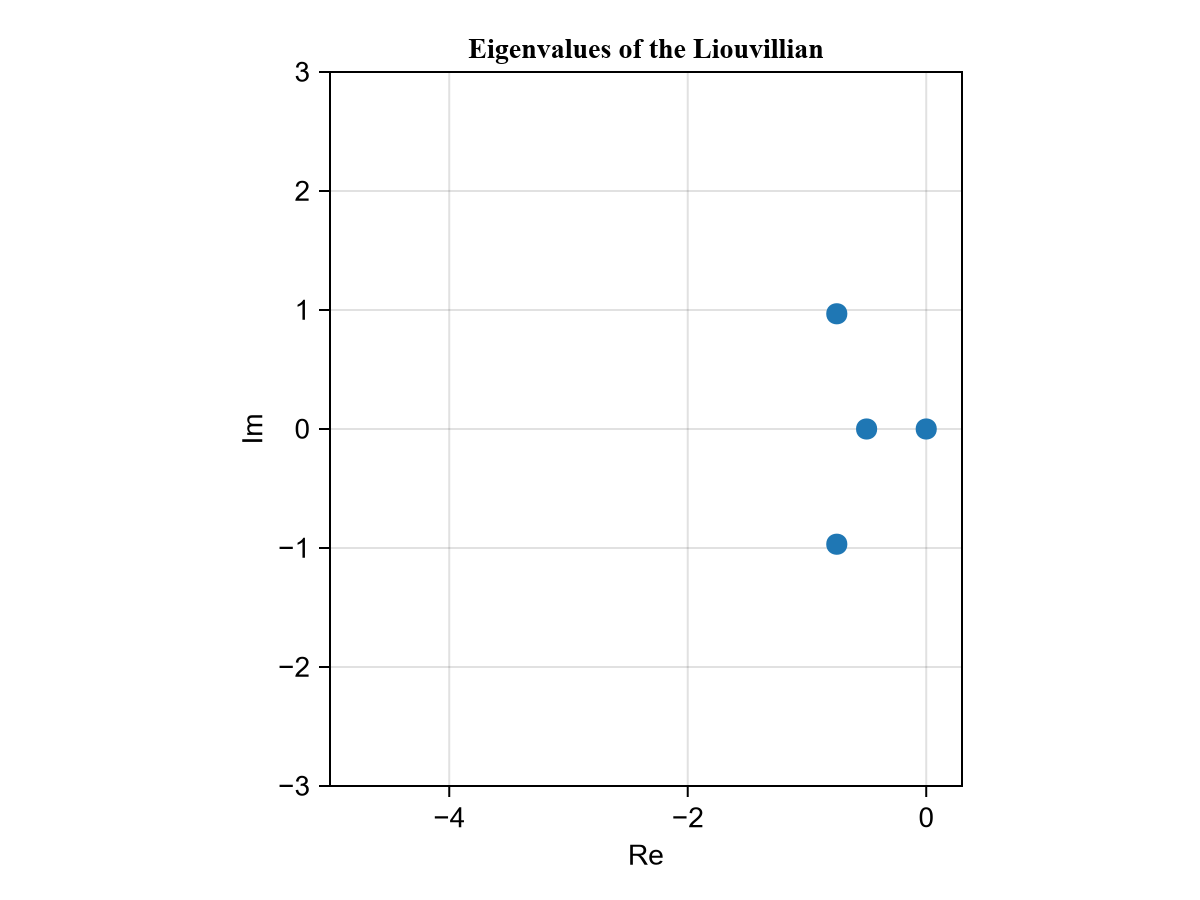

In [9]:
Ωlistt =[1] #List of Rabi frequencies

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel="Re", ylabel="Im",
    title="Eigenvalues of the Liouvillian",
    xgridvisible=true, ygridvisible=true,
    aspect=DataAspect(),
)

for (i,Ω) in enumerate(Ωlistt)
L = liouvillian(h(δ,Ω),J; rates=rates) 
vals=eigen(Matrix(L.data)).values

x = real.(vals)
y = imag.(vals)

CairoMakie.scatter!(ax, x, y, markersize=15,color=colors[i])
end

CairoMakie.xlims!(ax, -5, 0.3)
CairoMakie.ylims!(ax, -3, 3)

fig

## b) Discussing the significiance of the Liouvillian spectrum

With a first glance, it can be stated that as every Liouvillian spectrum, there is the $\lambda_0 = 0$ eigenvalue, it corresponds to the stationnary steady state. Moreover the fully real eigenvalue $\lambda_1$ (eigenvalue without any imaginary part) is negative and the two last eigenvalues are complex and constitue a conjugate pair, which is not surprising as the characteristic polynomial of the Liouvillian operator has real coefficients. In addition, as in our dynamics, we introduce the dissipative part $\Gamma_e \left( \sigma_- \rho_S \sigma_+ - \frac{1}{2} \left\{ \sigma_+ \sigma_-, \rho_S \right\} \right)$, there is not any fully imaginary conjugate pairs of eigenvalues.
Concerning the relaxation rates and the Liouvillian gap we have: as the temporal evolution of $\rho(t)$ is given by 
$$
|\rho(t)\rangle\rangle = \sum_n \rho(0) e^{\lambda_n t} P_n \ , 
$$
we have formally
$$
\lim_{t \to \infty} \rho(t) = \rho_{\text{ss}} = \lim_{t \to \infty} \rho(0)e^{\lambda_0 t} P_0 + \rho(0)e^{\lambda_1 t} P_1 + \rho(0)e^{\lambda_2 t} P_2 + \rho(0)e^{\lambda_3 t} P_3 = \rho(0)P_0
$$
because all the real part of the eigenvalues $\lambda_1, \lambda_2$ and $\lambda_3$ are negative.  
The Liouvillian gap $\Delta$ is defined by the smallest value of the real part in absolute value among the eigenvalues $\lambda_n$ for $n>1$. Thus here, the Liouvillian gap is $\Delta = |Re(\lambda_1)|$. Finally, this latter Liouvillian gap determines the relaxation time of the system as in the expression  
$$
|\rho(t)\rangle\rangle = \sum_n \rho(0) e^{\lambda_n t} P_n \
$$
the term that tends slower to 0 among the one related to the eigenvalues $\lambda_n$ for $n>0$ is the one with the smallest (in absolute value) real part. the in question term here is then 
$$
\rho(0)e^{\lambda_1 t}P_1 = \rho(0)e^{i Im(\lambda_1) t}e^{Re(\lambda_1) t}P_1 
$$

## c) Computing and plotting the characteristic relaxation times 

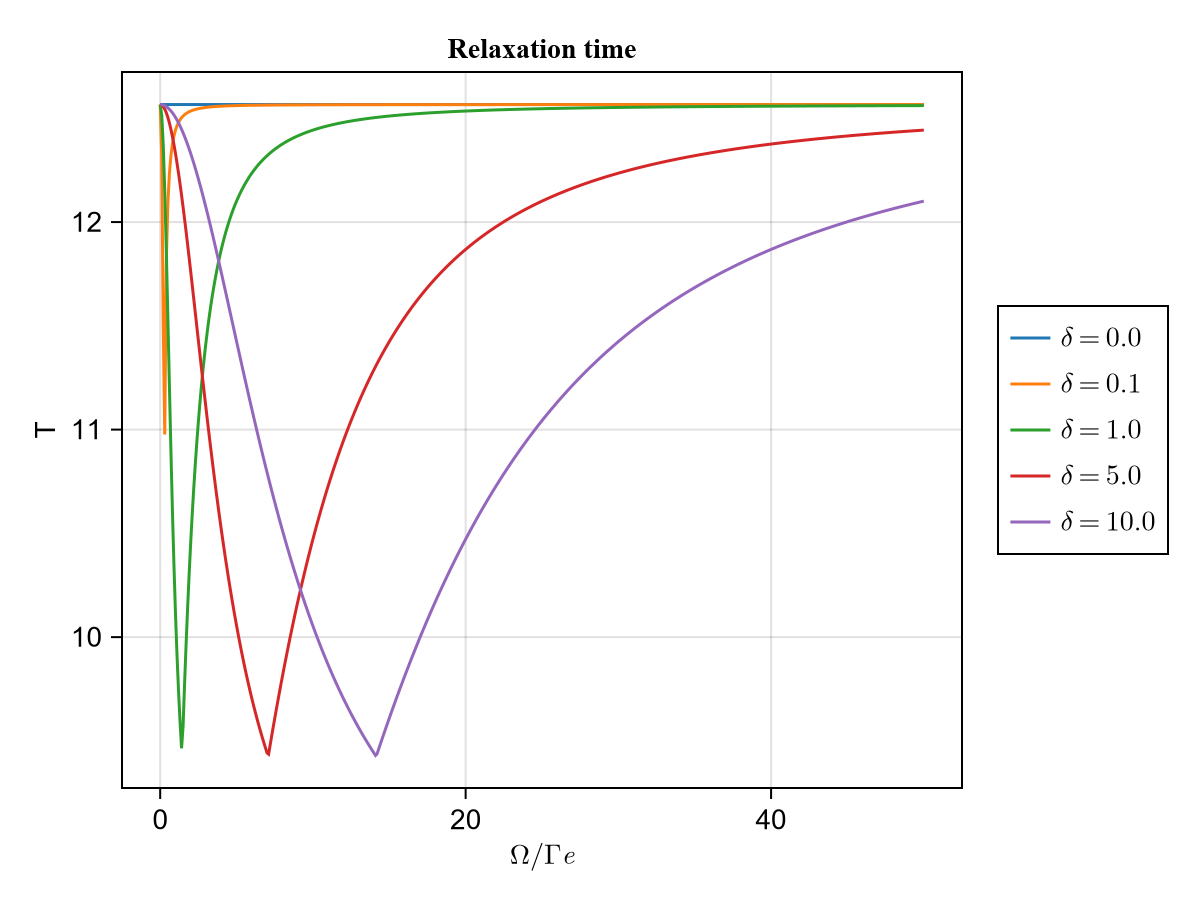

In [10]:
Ωlist = 0:0.1:50    #List of Rabi frequencies
δs = [0,0.1,1,5,10] #List of detuning

fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"Ω/Γe", ylabel="T",title="Relaxation time")

for (i,δ) in enumerate(δs)
    gaplist=[]
    for (j,Ω) in enumerate(Ωlist)
        L = liouvillian(h(δ,Ω),J; rates=rates) 
        vals=eigen(Matrix(L.data)).values
        top2 = partialsort(real(vals), 1:2; rev=true)
        gap = abs(top2[1]-top2[2])
        push!(gaplist,2*π/gap)
    end
    lines!(ax, Ωlist/Γe, gaplist, label=L"\delta=%$δ",color=colors[i])
end

Legend(fig[1,2],ax)
fig

## References